In [112]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image 
import os
from skimage import color


In [119]:
outputPath = './out/'
def ensurePath(path):
    if(not os.path.exists(path)):
        os.makedirs(path)

def setOutputPath(path):
    global outputPath
    outputPath = path
    ensurePath(outputPath)
    return path

def saveImage(image, name):
    global outputPath
    cv2.imwrite(outputPath + name, image)

def display_images(daylight, fluorescent):
    # display images using pyplot 
    plt.subplot(2, 2, 1)
    plt.title('Daylight Morning')
    plt.imshow(daylight[0], cmap='gray')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(2, 2, 2)
    plt.title('Daylight Afternoon')
    plt.imshow(daylight[1], cmap='gray')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(2, 2, 3)
    plt.title('Fluorescent Dim')
    plt.imshow(fluorescent[0], cmap='gray')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(2, 2, 4)
    plt.title('Fluorescent Bright')
    plt.imshow(fluorescent[1], cmap='gray')
    plt.xticks([])
    plt.yticks([])

    plt.show()

# Original Images

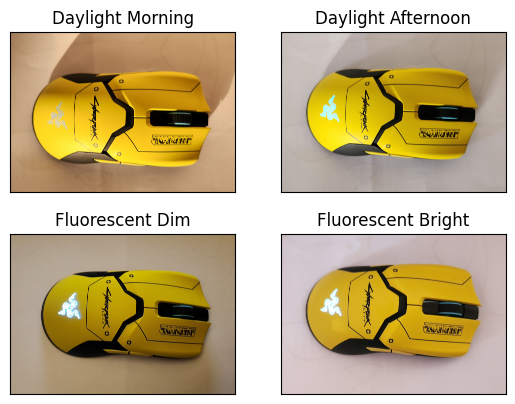

In [114]:
# Original Imaages
daylight = [
    np.array(Image.open('./img/daylight_morning.jpg')),
    np.array(Image.open('./img/daylight_afternoon.jpg'))
]
fluorescent = [
    np.array(Image.open('./img/fluorescent_dim.jpg')),
    np.array(Image.open('./img/fluorescent_bright.jpg'))
]

display_images(daylight, fluorescent)




# Task 3: grayscale

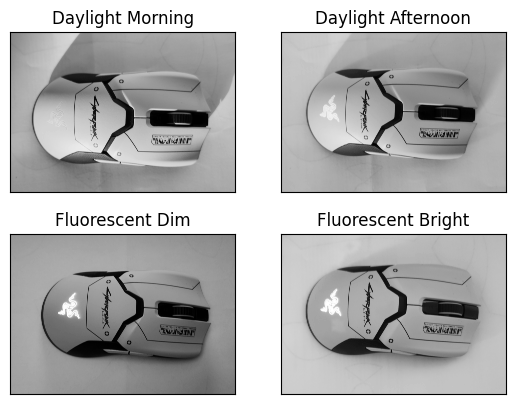

In [115]:
# convert to grayscale
def to_gray(img):
    return np.dot(img[...,:3], [0.299, 0.587, 0.114])

# convert daylight
daylight_gray = [to_gray(img) for img in daylight]
fluorescent_gray = [to_gray(img) for img in fluorescent]

# display grayscale images
display_images(daylight_gray, fluorescent_gray)


In [120]:
setOutputPath('./out/grayscale/')
saveImage(daylight_gray[0], 'daylight_morning_gray.jpg')
saveImage(daylight_gray[1], 'daylight_afternoon_gray.jpg')
saveImage(fluorescent_gray[0], 'fluorescent_dim_gray.jpg')
saveImage(fluorescent_gray[1], 'fluorescent_bright_gray.jpg')

# Task 4: discretization

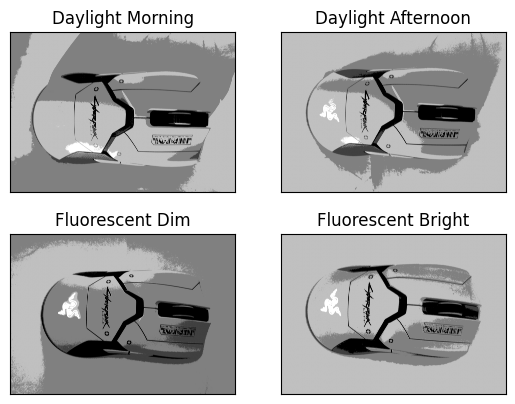

In [121]:
# Define the number of representative colors
n_colors = 4
# interval between each level
interval = 256 / n_colors
# discretization of grayscale images
daylight_disc = [np.round(img / interval) * interval for img in daylight_gray]
fluorescent_disc = [np.round(img / interval) * interval for img in fluorescent_gray]

# display results
display_images(daylight_disc, fluorescent_disc)

In [122]:
setOutputPath('./out/discretized/')
saveImage(daylight_disc[0], 'daylight_morning_disc.jpg')
saveImage(daylight_disc[1], 'daylight_afternoon_disc.jpg')
saveImage(fluorescent_disc[0], 'fluorescent_dim_disc.jpg')
saveImage(fluorescent_disc[1], 'fluorescent_bright_disc.jpg')

# Task 5: black and white

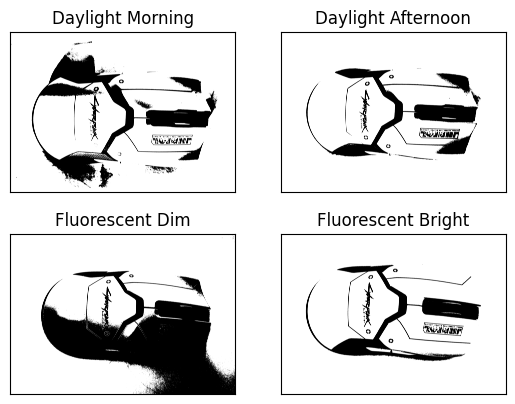

In [123]:
daylight_bw = [cv2.threshold(gray_img, 127, 255, cv2.THRESH_BINARY)[1] for gray_img in daylight_gray]
fluorescent_bw = [cv2.threshold(gray_img, 127, 255, cv2.THRESH_BINARY)[1] for gray_img in fluorescent_gray]

display_images(daylight_bw, fluorescent_bw)

In [124]:
setOutputPath('./out/bw/')
saveImage(daylight_bw[0], 'daylight_morning_bw.jpg')
saveImage(daylight_bw[1], 'daylight_afternoon_bw.jpg')
saveImage(fluorescent_bw[0], 'fluorescent_dim_bw.jpg')
saveImage(fluorescent_bw[1], 'fluorescent_bright_bw.jpg')

# Task 6: hue, saturation, and brightness

In [125]:
def changeHSL(img, dHSL):
    '''
    img: image in RGB
    dHSL: delta HSL. list of 3 values, each value is a float number
    
    dHSL[0] - change hue\n
    dHSL[1] - change saturation\n
    dHSL[2] - change lightness\n
    '''
    img_hsl = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # change hue
    img_hsl[:,:,0] = img_hsl[:,:,0] * dHSL[0]
    # change saturation 
    img_hsl[:,:,1] = img_hsl[:,:,1] * dHSL[1]
    # change lightness 
    img_hsl[:,:,2] = img_hsl[:,:,2] * dHSL[2]

    # change back to rgb
    return cv2.cvtColor(img_hsl, cv2.COLOR_HLS2RGB)


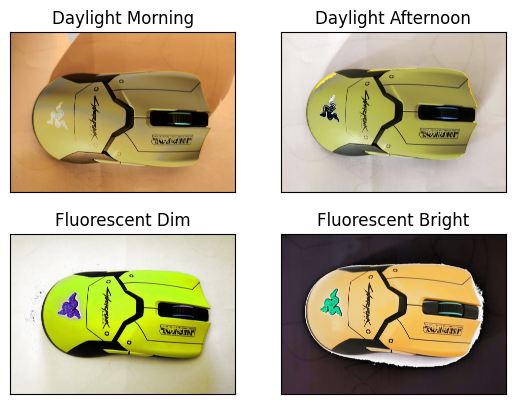

In [126]:
daylight_hsl_mod = [changeHSL(daylight[0], [1, 1, 1.5]), changeHSL(daylight[1], [1.2, 1.2, 1.5])]
fluorescent_hsl_mod = [changeHSL(fluorescent[0], [1.5, 1.5, 1.0]), changeHSL(fluorescent[1], [0.9, 1.5, 1])]

display_images(daylight_hsl_mod, fluorescent_hsl_mod)

In [127]:
# reverse the color channels
daylight_hsl_mod = [cv2.cvtColor(img, cv2.COLOR_RGB2BGR) for img in daylight_hsl_mod]
fluorescent_hsl_mod = [cv2.cvtColor(img, cv2.COLOR_RGB2BGR) for img in fluorescent_hsl_mod]

setOutputPath('./out/hsl/')
saveImage(daylight_hsl_mod[0], 'daylight_morning_hsl.jpg')
saveImage(daylight_hsl_mod[1], 'daylight_afternoon_hsl.jpg')
saveImage(fluorescent_hsl_mod[0], 'fluorescent_dim_hsl.jpg')
saveImage(fluorescent_hsl_mod[1], 'fluorescent_bright_hsl.jpg')

# Task 7: color closeness

In [129]:
import threading
from tqdm import tqdm
# find close colors using skimage and ciede2000
def find_close_colors(pixel, threshold, image, highlight_color=(255, 0, 0), desc="Progress:"):
    '''
    pixel: pixel to find close colors
    threshold: threshold to find close colors
    image: image to find close colors
    '''
    retval = image.copy()
    for x in tqdm(range(len(image)), desc=desc):
        def process(x, retval, pixel, threshold, image, highlight_color):
            for y in range(len(image[x])):
                diff = color.deltaE_ciede2000(color.rgb2lab(pixel), color.rgb2lab(retval[x][y]))
                if diff <= threshold:
                    retval[x][y] = highlight_color
        
        # make it multi-threaded
        t = threading.Thread(target=process, args=(x, retval, pixel, threshold, image, highlight_color))
        t.start()
        
    return retval

In [142]:
daylight_closeness = daylight.copy()
fluorescent_closeness = fluorescent.copy()

# resize images
daylight_closeness = [cv2.resize(img, (800, 600)) for img in daylight_closeness]
fluorescent_closeness = [cv2.resize(img, (800, 600)) for img in fluorescent_closeness]

# threshold for close colors
threshold = 10
setOutputPath('./out/close_colors/background/')
print("Finding close colors for the pixel on the Object...")
# find close colors of the object for daylight images
daylight_closeness[0] = find_close_colors(daylight_closeness[0][100, 200], threshold, daylight_closeness[0], desc="Daylight Morning")
daylight_closeness[0] = cv2.cvtColor(daylight_closeness[0], cv2.COLOR_RGB2BGR)
saveImage(daylight_closeness[0], 'daylight_morning.jpg')

daylight_closeness[1] = find_close_colors(daylight_closeness[1][100, 200], threshold, daylight_closeness[1], desc="Daylight Afternoon")
daylight_closeness[1] = cv2.cvtColor(daylight_closeness[1], cv2.COLOR_RGB2BGR)
saveImage(daylight_closeness[1], 'daylight_afternoon.jpg')

# find close colors of the object for fluorescent images
fluorescent_closeness[0] = find_close_colors(fluorescent_closeness[0][100, 200], threshold, fluorescent_closeness[0], desc="Fluorescent Dim")
fluorescent_closeness[0] = cv2.cvtColor(fluorescent_closeness[0], cv2.COLOR_RGB2BGR)
saveImage(fluorescent_closeness[0], 'fluorescent_dim.jpg')

fluorescent_closeness[1] = find_close_colors(fluorescent_closeness[1][100, 200], threshold, fluorescent_closeness[1], desc="Fluorescent Brighty")
fluorescent_closeness[1] = cv2.cvtColor(fluorescent_closeness[1], cv2.COLOR_RGB2BGR)
saveImage(fluorescent_closeness[1], 'fluorescent_bright.jpg')



Finding close colors for the pixel on the Object...


Fluorescent Brighty: 100%|██████████| 600/600 [02:06<00:00,  4.73it/s]


In [141]:
daylight_closeness = daylight.copy()
fluorescent_closeness = fluorescent.copy()

# resize images
daylight_closeness = [cv2.resize(img, (800, 600)) for img in daylight_closeness]
fluorescent_closeness = [cv2.resize(img, (800, 600)) for img in fluorescent_closeness]

# threshold for close colors
threshold = 15
setOutputPath('./out/close_colors/objects/')
print("Finding close colors for the pixel on the Object...")
# find close colors of the object for daylight images
daylight_closeness[0] = find_close_colors(daylight_closeness[0][180, 210], threshold, daylight_closeness[0], desc="Daylight Morning")
daylight_closeness[0] = cv2.cvtColor(daylight_closeness[0], cv2.COLOR_RGB2BGR)
saveImage(daylight_closeness[0], 'daylight_morning.jpg')

daylight_closeness[1] = find_close_colors(daylight_closeness[1][200, 400], threshold, daylight_closeness[1], desc="Daylight Afternoon")
daylight_closeness[1] = cv2.cvtColor(daylight_closeness[1], cv2.COLOR_RGB2BGR)
saveImage(daylight_closeness[1], 'daylight_afternoon.jpg')

# find close colors of the object for fluorescent images
fluorescent_closeness[0] = find_close_colors(fluorescent_closeness[0][200, 400], threshold, fluorescent_closeness[0], desc="Fluorescent Dim")
fluorescent_closeness[0] = cv2.cvtColor(fluorescent_closeness[0], cv2.COLOR_RGB2BGR)
saveImage(fluorescent_closeness[0], 'fluorescent_dim.jpg')

fluorescent_closeness[1] = find_close_colors(fluorescent_closeness[1][200, 400], threshold, fluorescent_closeness[1], desc="Fluorescent Brighty")
fluorescent_closeness[1] = cv2.cvtColor(fluorescent_closeness[1], cv2.COLOR_RGB2BGR)
saveImage(fluorescent_closeness[1], 'fluorescent_bright.jpg')

Finding close colors for the pixel on the Object...


Fluorescent Brighty: 100%|██████████| 600/600 [02:00<00:00,  5.00it/s]
